# Initial Data Exploration

Necessary imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Disable warnings

In [3]:
import warnings
warnings.simplefilter('ignore')

Read the unzipped dataset file

In [4]:
filtered = pd.read_csv('../data/raw/filtered.tsv', sep='\t')

In [5]:
filtered.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


So, the dataset has 6 features: 
1. The reference text - text
2. The translated text - text
3. The measure of similarity between the two - number
4. The length difference - number
5. The toxicity of the reference text - number
6. The toxicity of the translated text - number

To explore the data, good starting point would be to plot `ref_tox` and `trn_tox`

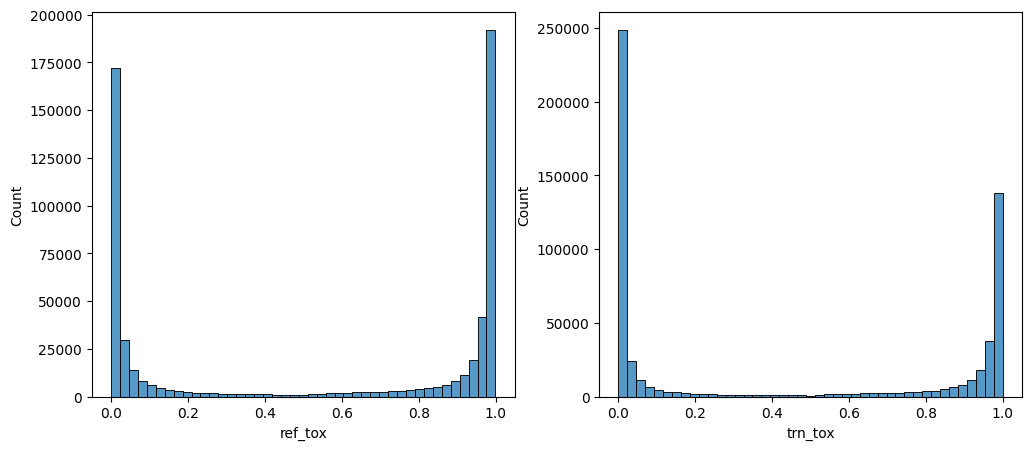

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(data=filtered, x='ref_tox')
plt.subplot(122)
sns.histplot(data=filtered, x='trn_tox')
plt.show()

So, both of these variables are between $0$ and $1$, and have spikes on $0$ and $1$.

To find out whether there is correlation between these two variables, 2d histogram can be used.

<Axes: xlabel='ref_tox', ylabel='trn_tox'>

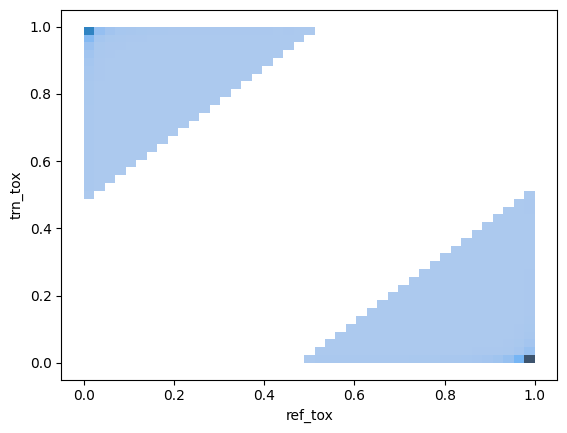

In [7]:
sns.histplot(filtered, x='ref_tox', y='trn_tox')

As expected, there are a lot of cases where `ref_tox` $\approx 1$, and `trn_tox` $\approx 0$. However, there are also cases there the inverse is true. Addressing these data points might help with the training of the model. 

Simple histograms of similarity and length difference:

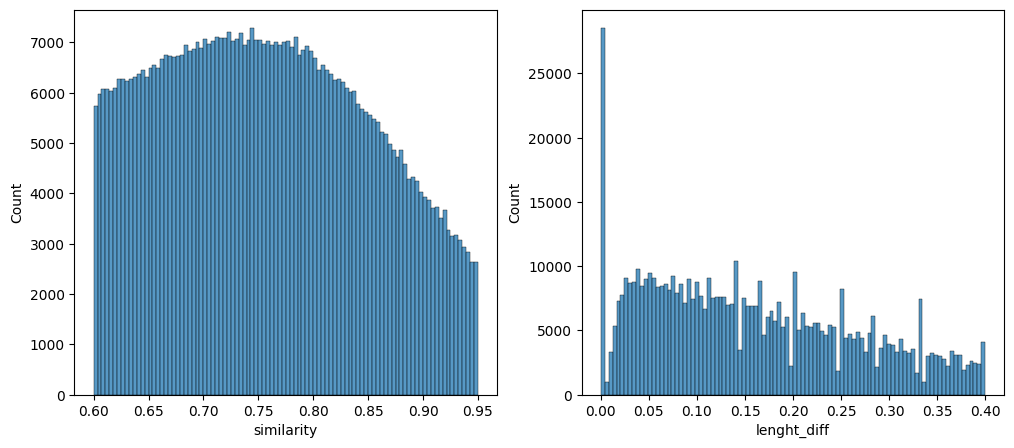

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(data=filtered, x='similarity')
plt.subplot(122)
sns.histplot(data=filtered, x='lenght_diff')
plt.show()

The distributions are unremarkable, the similarity is between $0.6$ and $0.95$, the length difference is between $0$ and $.4$, with a significant spike at $0$.

A good way to explore text data might be to build a word cloud.

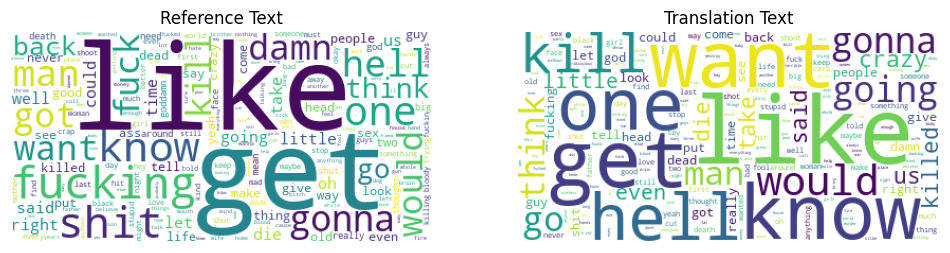

In [69]:
import wordcloud
import re
import collections
import nltk
import nltk.corpus

# Download stopwords
nltk.download('stopwords', quiet=True)
stopwords = nltk.corpus.stopwords.words("english")

# Build the reference text wordcloud
reference_text = ' '.join(filtered.reference.tolist()).lower()
reference_words = re.findall('[a-z]+', reference_text)
reference_counts = collections.Counter(reference_words)
reference_no_stopwords = reference_counts.copy()
for stopword in stopwords:
    if stopword in reference_no_stopwords:
        reference_no_stopwords.pop(stopword)
reference_cloud = wordcloud.WordCloud(background_color='white').fit_words(reference_no_stopwords)

# Build the translation text wordcloud
translated_text = ' '.join(filtered.translation.tolist()).lower()
translated_words = re.findall('[a-z]+', translated_text)
translated_counts = collections.Counter(translated_words)
translated_no_stopwords = translated_counts.copy()
for stopword in stopwords:
    if stopword in translated_no_stopwords:
        translated_no_stopwords.pop(stopword)
translated_cloud = wordcloud.WordCloud(background_color='white').fit_words(translated_no_stopwords)

# Plot both clouds
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(reference_cloud)
axs[0].axis('off')
axs[0].set_title('Reference Text')
axs[1].imshow(translated_cloud)
axs[1].axis('off')
axs[1].set_title('Translation Text')
plt.show()

As expected, the reference text includes a lot of toxic words. Possibly because of the high-toxicity translated sentences, words similar to "kill" are still present in the translated text. Thus, the necessary preprocessing step is to swap translated and reference sequences where `ref_tox` < `trn_tox`.